In [86]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as tf
from sklearn.metrics import r2_score

In [87]:
sp500=yf.download('^GSPC',start="2021-03-07", end="2023-03-01",interval='1h')

[*********************100%***********************]  1 of 1 completed


In [88]:
minmax = MinMaxScaler(feature_range = (0,1) )
sp500['Adj Close'] = minmax.fit_transform(np.array(sp500['Adj Close']).reshape(-1,1))

<Axes: xlabel='Datetime'>

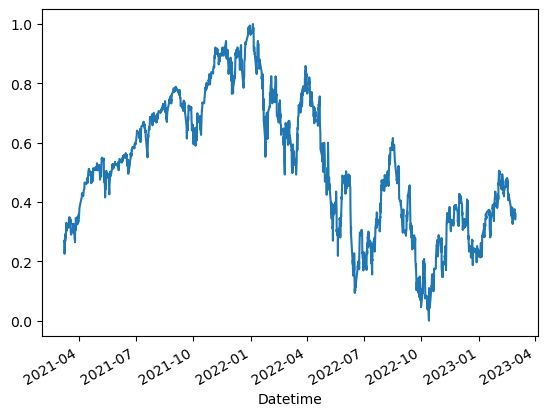

In [89]:
sp500['Adj Close'].plot()

In [90]:
def rnn_set(dt,set):
    x_train=list()
    for x in range(len(dt)-set):
        a=list([c] for c in dt[(x):(x+set)])
        # y_train=[y,y_train]
        x_train.append(a)
    return np.array(x_train)

In [91]:
rnn_set(sp500['Adj Close'],60).shape

(3425, 60, 1)

In [92]:
X_train=rnn_set(sp500['Adj Close'],60)[:3375]

In [93]:
X_test=rnn_set(sp500['Adj Close'],60)[3375:]

In [94]:
y_train=np.array(sp500['Adj Close'][60:3375+60])

In [95]:
y_test=np.array(sp500['Adj Close'][3375+60:])

In [96]:
lstm_rnn1 = tf.models.load_model('lstm_rnn1')

C:\Users\hp\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


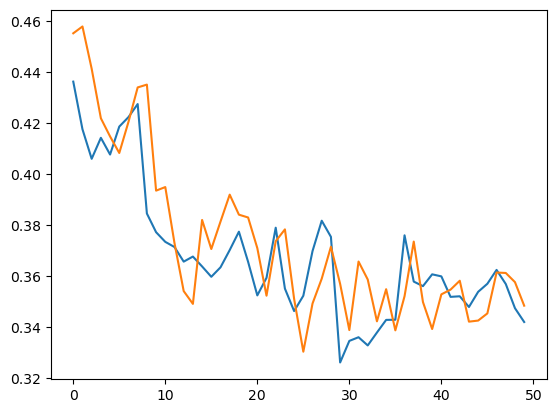

In [97]:
plt.plot(pd.DataFrame(y_test))
plt.plot(pd.DataFrame(lstm_rnn1.predict_generator(X_test,dy)))

In [98]:
r2_score(lstm_rnn1.predict_generator(X_test), y_test)

0.6887313533217183

In [99]:
pred=pd.DataFrame(lstm_rnn1.predict_generator(X_test),columns=['Predicted']).diff()

C:\Users\hp\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [100]:
pred['Actual']=pd.DataFrame(y_test).diff()

In [101]:
pred_TF=pd.DataFrame({"Predicted":pred['Predicted']>0,"Actual":pred['Actual']>0})

In [102]:
pred_TF['xx']=pred_TF['Predicted']==pred_TF['Actual']

In [103]:
len(pred_TF[pred_TF['xx']==True])

31

In [104]:
len(pred_TF[pred_TF['xx']==False])

19

In [105]:
len(pred_TF[pred_TF['xx']==True]) / (len(pred_TF[pred_TF['xx']==True]) + len(pred_TF[pred_TF['xx']==False]))

0.62

In [106]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(X_test, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    
    #using our ranges we plot X_init
    #and test and actual preds
    plt.plot(sp500.index[3375+60:], y_test, color='orange')
    plt.plot(sp500.index[3375+60:], y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

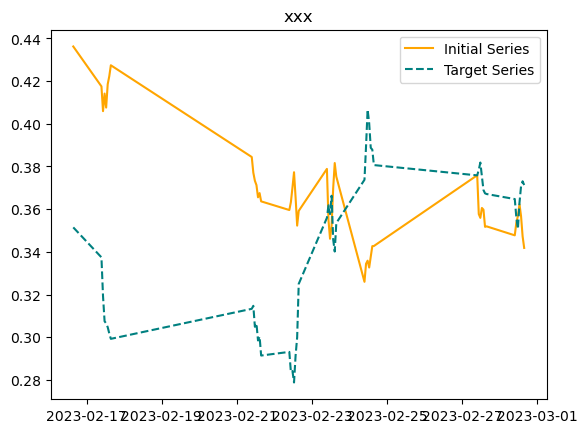

In [107]:
predict_and_plot(X_test,y_test,lstm_rnn1,'xxx')